# Using segmentation_models module for semantic segmentation

## Splitting the dataset into train-val-test sets

In [1]:
# import os
# import shutil
# import random

# # Input directories
# damaged_img_dir = '../../data/damaged-and-mask-dataset/generated-damaged-images'
# damage_mask_dir = '../../data/damaged-and-mask-dataset/generated-damage-masks'

# # Output directories
# train_img_dir = '../../data/damaged-and-mask-dataset/img-with-val/train'
# val_img_dir   = '../../data/damaged-and-mask-dataset/img-with-val/val'
# test_img_dir  = '../../data/damaged-and-mask-dataset/img-with-val/test'

# train_mask_dir = '../../data/damaged-and-mask-dataset/mask-with-val/train'
# val_mask_dir   = '../../data/damaged-and-mask-dataset/mask-with-val/val'
# test_mask_dir  = '../../data/damaged-and-mask-dataset/mask-with-val/test'

# # Create directories if they don't exist
# for d in [train_img_dir, val_img_dir, test_img_dir, train_mask_dir, val_mask_dir, test_mask_dir]:
#     os.makedirs(d, exist_ok=True)

# # Get and shuffle list of image filenames
# all_images = [f for f in os.listdir(damaged_img_dir) if f.lower().endswith('.png')]
# random.seed(42)
# random.shuffle(all_images)

# # Compute split indices
# n_total = len(all_images)
# n_train = int(0.70 * n_total)
# n_val = int(0.15 * n_total)
# n_test = n_total - n_train - n_val

# # Split images
# train_images = all_images[:n_train]
# val_images = all_images[n_train:n_train + n_val]
# test_images = all_images[n_train + n_val:]

# # Copy function
# def copy_files(img_list, target_img_dir, target_mask_dir):
#     for fname in img_list:
#         src_img_path = os.path.join(damaged_img_dir, fname)
#         dst_img_path = os.path.join(target_img_dir, fname)
#         shutil.copy(src_img_path, dst_img_path)

#         base_name = fname.replace('.png', '')
#         mask_name = f'{base_name}-mask.png'
#         src_mask_path = os.path.join(damage_mask_dir, mask_name)
#         dst_mask_path = os.path.join(target_mask_dir, mask_name)
#         if os.path.exists(src_mask_path):
#             shutil.copy(src_mask_path, dst_mask_path)
#         else:
#             print(f'Warning: mask for {fname} not found')

# # Perform copying
# copy_files(train_images, train_img_dir, train_mask_dir)
# copy_files(val_images, val_img_dir, val_mask_dir)
# copy_files(test_images, test_img_dir, test_mask_dir)

# print(f"Split complete: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")


In [2]:
# import os

# def count_dataset_files(base_dir, ext='.png'):
#     subdirs = {
#         'Train Images': 'img-with-val/train',
#         'Val Images': 'img-with-val/val',
#         'Test Images': 'img-with-val/test',
#         'Train Masks': 'mask-with-val/train',
#         'Val Masks': 'mask-with-val/val',
#         'Test Masks': 'mask-with-val/test',
#     }

#     for label, subpath in subdirs.items():
#         full_path = os.path.join(base_dir, subpath)
#         if os.path.exists(full_path):
#             count = len([
#                 f for f in os.listdir(full_path)
#                 if f.lower().endswith(ext) and os.path.isfile(os.path.join(full_path, f))
#             ])
#             print(f"{label}: {count}")
#         else:
#             print(f"{label}: Directory not found")

# # Example usage:
# count_dataset_files('../../data/damaged-and-mask-dataset')

# Train Images: 24205
# Val Images: 5186
# Test Images: 5188
# Train Masks: 24205
# Val Masks: 5186
# Test Masks: 5188

## Loading the dataset

In [3]:
import os

os.environ['SM_FRAMEWORK'] = 'tf.keras'

# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Image augmentation
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform

# Segmentation Models
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [4]:
print(sm.framework())  # should output: 'tf.keras'

tf.keras


In [5]:
DATA_DIR = "../../data/damaged-and-mask-dataset/"

In [6]:
x_train_dir = os.path.join(DATA_DIR, "img-with-val/train")
y_train_dir = os.path.join(DATA_DIR, "mask-with-val/train")

x_valid_dir = os.path.join(DATA_DIR, "img-with-val/val")
y_valid_dir = os.path.join(DATA_DIR, "mask-with-val/val")

x_test_dir = os.path.join(DATA_DIR, "img-with-val/test")
y_test_dir = os.path.join(DATA_DIR, "mask-with-val/test")

## Dataloader and utility functions

In [7]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# classes for data loading and preprocessing
class Dataset:
    """Damage Detection Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transformation pipeline 
        preprocessing (albumentations.Compose): data preprocessing pipeline
    """
    
    CLASSES = ['damage']  # single-class binary segmentation
    
    def __init__(
        self, 
        images_dir, 
        masks_dir, 
        classes=None, 
        augmentation=None, 
        preprocessing=None,
        subset_size=None  # NEW
    ):
        self.all_ids = os.listdir(masks_dir)
        self.base_ids = [mask_id.replace('-mask.png', '') for mask_id in self.all_ids]
        
        # Apply subset sampling
        if subset_size:
            n = int(len(self.base_ids) * subset_size) if isinstance(subset_size, float) else subset_size
            self.base_ids = self.base_ids[:n]
            self.all_ids = self.all_ids[:n]

        self.ids = self.all_ids
        
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.all_ids]
        self.images_fps = [os.path.join(images_dir, base_id + '.png') for base_id in self.base_ids]
    
        for path in self.images_fps:
            if not os.path.exists(path):
                raise FileNotFoundError(f"Image not found: {path}")
        
        self.class_values = [1]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        if image is None:
            raise FileNotFoundError(f"Failed to read image at: {self.images_fps[i]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        mask_path = self.masks_fps[i]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Failed to read mask at: {mask_path}")
    
        mask = np.where(mask > 0, 1, 0).astype('float32')
        mask = np.expand_dims(mask, axis=-1)
    
        # Apply augmentation
        if self.augmentation is not None:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]
    
        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]
    
        image = image.astype("float32")
        return image, mask
        
    def __len__(self):
        return len(self.ids)


class Dataloder(Sequence):
    """Load data from dataset and form batches"""
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


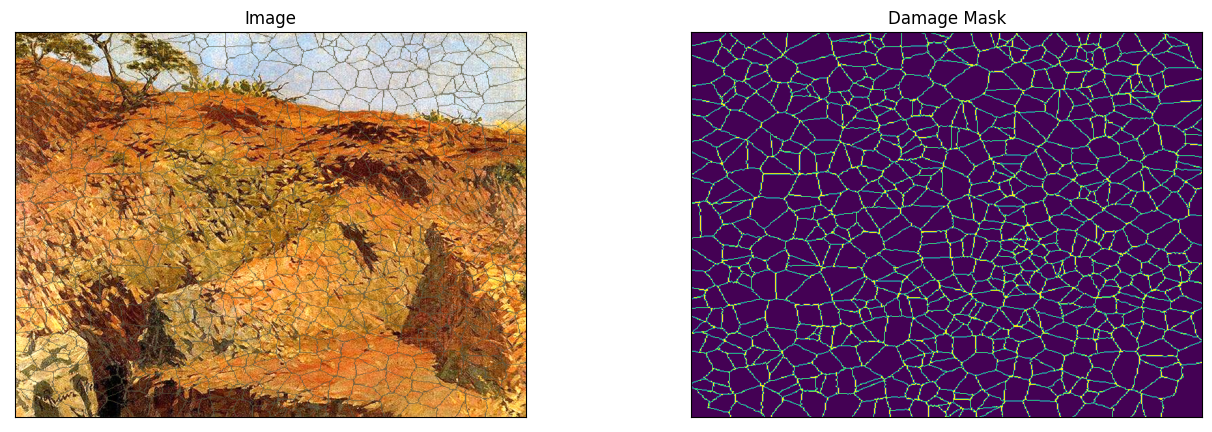

In [8]:
# Let's look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['damage'])

image, mask = dataset[5]  # get some sample
visualize(
    image=denormalize(image),
    damage_mask=mask[..., 0].squeeze()
)


## Augmentations

In [9]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# Define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(
            scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0
        ),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.Perspective(scale=(0.05, 0.1), keep_size=True, p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(brightness_limit=0.2, p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),

        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(min_height=384, min_width=480)
    ]
    return A.Compose(test_transform)


def build_preprocessing(preprocessing_fn=None):
    return A.Compose([
        A.Lambda(
            image=preprocessing_fn if preprocessing_fn else (lambda x, **kwargs: x),
            mask=lambda x, **kwargs: x
        )
    ])


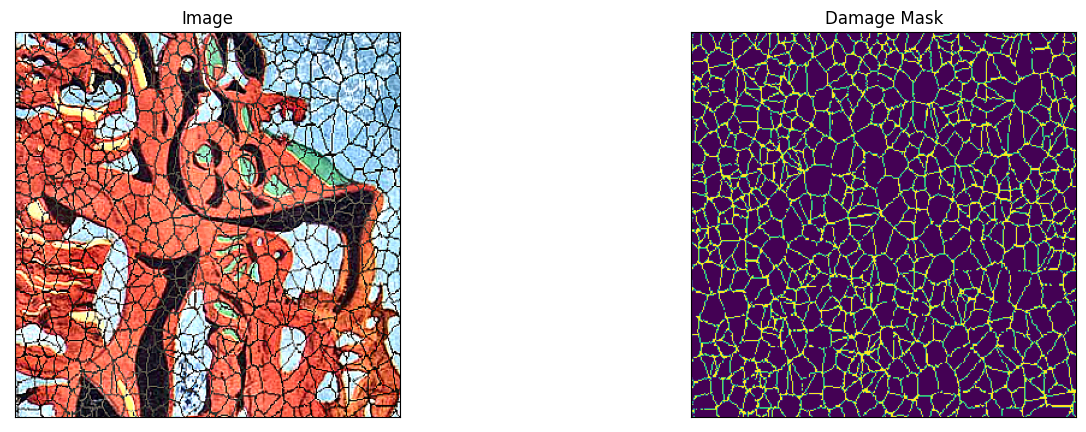

In [10]:
# Let's look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['damage'], augmentation=get_training_augmentation())

image, mask = dataset[12]  # get some sample
visualize(
    image=denormalize(image),
    damage_mask=mask[..., 0].squeeze(),
)


## Segmentation and model training

In [11]:
# Model and training configuration
BACKBONE = "resnext50"
BATCH_SIZE = 8
CLASSES = ["damage"]
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

def build_preprocessing(preprocessing_fn=None):
    return A.Compose([
        A.Lambda(
            image=lambda x, **kwargs: preprocessing_fn(x) if preprocessing_fn else x,
            mask=lambda x, **kwargs: x
        )
    ])

# Now wrap the preprocessing function in an albumentations pipeline
preprocessing = build_preprocessing(preprocess_input)

/home/msds2025/cjasmin/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1778: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [12]:
# Define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # add background if multiclass
activation = 'sigmoid' if n_classes == 1 else 'softmax'     # use sigmoid for binary, softmax for multiclass

# Create U-Net model with chosen backbone and parameters
model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
    encoder_freeze=False,  # ← if supported
    classes=n_classes,
    activation=activation
)

In [13]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(LR)

# Define loss components
dice_loss = sm.losses.DiceLoss()
if n_classes == 1:
    focal_loss = sm.losses.BinaryFocalLoss()
    total_loss = dice_loss + focal_loss  # or sm.losses.binary_focal_dice_loss
else:
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + focal_loss  # or sm.losses.categorical_focal_dice_loss

# Define metrics
metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5)
]

# Compile model
model.compile(
    optimizer=optimizer,
    loss=total_loss,
    metrics=metrics
)

In [14]:
# Use only 5% of each split
SUBSET = 0.05

# Dataset for training images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=preprocessing,
    subset_size=SUBSET,
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=preprocessing,
    subset_size=SUBSET,
)

# DataLoaders
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# Shape checks (sanity check for input/output)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# Define callbacks: model checkpointing and learning rate reduction
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='./best_model.h5',
        save_weights_only=True,
        save_best_only=True,
        mode='min'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    ),
]


In [15]:
# Train model using tf.keras API
history = model.fit(
    x=train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),
    callbacks=callbacks,
)


Epoch 1/40


ValueError: in user code:

    /home/msds2025/cjasmin/.conda/envs/sm-legacy/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/msds2025/cjasmin/.conda/envs/sm-legacy/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/msds2025/cjasmin/.conda/envs/sm-legacy/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/msds2025/cjasmin/.conda/envs/sm-legacy/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/msds2025/cjasmin/.conda/envs/sm-legacy/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:541 train_step  **
        self.trainable_variables)
    /home/msds2025/cjasmin/.conda/envs/sm-legacy/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1804 _minimize
        trainable_variables))
    /home/msds2025/cjasmin/.conda/envs/sm-legacy/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:521 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /home/msds2025/cjasmin/.conda/envs/sm-legacy/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1219 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['bn_data/beta:0', 'conv0/kernel:0', 'bn0/gamma:0', 'bn0/beta:0', 'stage1_unit1_conv1/kernel:0', 'stage1_unit1_bn1/gamma:0', 'stage1_unit1_bn1/beta:0', 'conv2d/kernel:0', 'conv2d_1/kernel:0', 'conv2d_2/kernel:0', 'conv2d_3/kernel:0', 'conv2d_4/kernel:0', 'conv2d_5/kernel:0', 'conv2d_6/kernel:0', 'conv2d_7/kernel:0', 'conv2d_8/kernel:0', 'conv2d_9/kernel:0', 'conv2d_10/kernel:0', 'conv2d_11/kernel:0', 'conv2d_12/kernel:0', 'conv2d_13/kernel:0', 'conv2d_14/kernel:0', 'conv2d_15/kernel:0', 'conv2d_16/kernel:0', 'conv2d_17/kernel:0', 'conv2d_18/kernel:0', 'conv2d_19/kernel:0', 'conv2d_20/kernel:0', 'conv2d_21/kernel:0', 'conv2d_22/kernel:0', 'conv2d_23/kernel:0', 'conv2d_24/kernel:0', 'conv2d_25/kernel:0', 'conv2d_26/kernel:0', 'conv2d_27/kernel:0', 'conv2d_28/kernel:0', 'conv2d_29/kernel:0', 'conv2d_30/kernel:0', 'conv2d_31/kernel:0', 'stage1_unit1_bn2/gamma:0', 'stage1_unit1_bn2/beta:0', 'stage1_unit1_conv3/kernel:0', 'stage1_unit1_sc/kernel:0', 'stage1_unit1_bn3/gamma:0', 'stage1_unit1_bn3/beta:0', 'stage1_unit1_sc_bn/gamma:0', 'stage1_unit1_sc_bn/beta:0', 'stage1_unit2_conv1/kernel:0', 'stage1_unit2_bn1/gamma:0', 'stage1_unit2_bn1/beta:0', 'conv2d_32/kernel:0', 'conv2d_33/kernel:0', 'conv2d_34/kernel:0', 'conv2d_35/kernel:0', 'conv2d_36/kernel:0', 'conv2d_37/kernel:0', 'conv2d_38/kernel:0', 'conv2d_39/kernel:0', 'conv2d_40/kernel:0', 'conv2d_41/kernel:0', 'conv2d_42/kernel:0', 'conv2d_43/kernel:0', 'conv2d_44/kernel:0', 'conv2d_45/kernel:0', 'conv2d_46/kernel:0', 'conv2d_47/kernel:0', 'conv2d_48/kernel:0', 'conv2d_49/kernel:0', 'conv2d_50/kernel:0', 'conv2d_51/kernel:0', 'conv2d_52/kernel:0', 'conv2d_53/kernel:0', 'conv2d_54/kernel:0', 'conv2d_55/kernel:0', 'conv2d_56/kernel:0', 'conv2d_57/kernel:0', 'conv2d_58/kernel:0', 'conv2d_59/kernel:0', 'conv2d_60/kernel:0', 'conv2d_61/kernel:0', 'conv2d_62/kernel:0', 'conv2d_63/kernel:0', 'stage1_unit2_bn2/gamma:0', 'stage1_unit2_bn2/beta:0', 'stage1_unit2_conv3/kernel:0', 'stage1_unit2_bn3/gamma:0', 'stage1_unit2_bn3/beta:0', 'stage1_unit3_conv1/kernel:0', 'stage1_unit3_bn1/gamma:0', 'stage1_unit3_bn1/beta:0', 'conv2d_64/kernel:0', 'conv2d_65/kernel:0', 'conv2d_66/kernel:0', 'conv2d_67/kernel:0', 'conv2d_68/kernel:0', 'conv2d_69/kernel:0', 'conv2d_70/kernel:0', 'conv2d_71/kernel:0', 'conv2d_72/kernel:0', 'conv2d_73/kernel:0', 'conv2d_74/kernel:0', 'conv2d_75/kernel:0', 'conv2d_76/kernel:0', 'conv2d_77/kernel:0', 'conv2d_78/kernel:0', 'conv2d_79/kernel:0', 'conv2d_80/kernel:0', 'conv2d_81/kernel:0', 'conv2d_82/kernel:0', 'conv2d_83/kernel:0', 'conv2d_84/kernel:0', 'conv2d_85/kernel:0', 'conv2d_86/kernel:0', 'conv2d_87/kernel:0', 'conv2d_88/kernel:0', 'conv2d_89/kernel:0', 'conv2d_90/kernel:0', 'conv2d_91/kernel:0', 'conv2d_92/kernel:0', 'conv2d_93/kernel:0', 'conv2d_94/kernel:0', 'conv2d_95/kernel:0', 'stage1_unit3_bn2/gamma:0', 'stage1_unit3_bn2/beta:0', 'stage1_unit3_conv3/kernel:0', 'stage1_unit3_bn3/gamma:0', 'stage1_unit3_bn3/beta:0', 'stage2_unit1_conv1/kernel:0', 'stage2_unit1_bn1/gamma:0', 'stage2_unit1_bn1/beta:0', 'conv2d_96/kernel:0', 'conv2d_97/kernel:0', 'conv2d_98/kernel:0', 'conv2d_99/kernel:0', 'conv2d_100/kernel:0', 'conv2d_101/kernel:0', 'conv2d_102/kernel:0', 'conv2d_103/kernel:0', 'conv2d_104/kernel:0', 'conv2d_105/kernel:0', 'conv2d_106/kernel:0', 'conv2d_107/kernel:0', 'conv2d_108/kernel:0', 'conv2d_109/kernel:0', 'conv2d_110/kernel:0', 'conv2d_111/kernel:0', 'conv2d_112/kernel:0', 'conv2d_113/kernel:0', 'conv2d_114/kernel:0', 'conv2d_115/kernel:0', 'conv2d_116/kernel:0', 'conv2d_117/kernel:0', 'conv2d_118/kernel:0', 'conv2d_119/kernel:0', 'conv2d_120/kernel:0', 'conv2d_121/kernel:0', 'conv2d_122/kernel:0', 'conv2d_123/kernel:0', 'conv2d_124/kernel:0', 'conv2d_125/kernel:0', 'conv2d_126/kernel:0', 'conv2d_127/kernel:0', 'stage2_unit1_bn2/gamma:0', 'stage2_unit1_bn2/beta:0', 'stage2_unit1_conv3/kernel:0', 'stage2_unit1_sc/kernel:0', 'stage2_unit1_bn3/gamma:0', 'stage2_unit1_bn3/beta:0', 'stage2_unit1_sc_bn/gamma:0', 'stage2_unit1_sc_bn/beta:0', 'stage2_unit2_conv1/kernel:0', 'stage2_unit2_bn1/gamma:0', 'stage2_unit2_bn1/beta:0', 'conv2d_128/kernel:0', 'conv2d_129/kernel:0', 'conv2d_130/kernel:0', 'conv2d_131/kernel:0', 'conv2d_132/kernel:0', 'conv2d_133/kernel:0', 'conv2d_134/kernel:0', 'conv2d_135/kernel:0', 'conv2d_136/kernel:0', 'conv2d_137/kernel:0', 'conv2d_138/kernel:0', 'conv2d_139/kernel:0', 'conv2d_140/kernel:0', 'conv2d_141/kernel:0', 'conv2d_142/kernel:0', 'conv2d_143/kernel:0', 'conv2d_144/kernel:0', 'conv2d_145/kernel:0', 'conv2d_146/kernel:0', 'conv2d_147/kernel:0', 'conv2d_148/kernel:0', 'conv2d_149/kernel:0', 'conv2d_150/kernel:0', 'conv2d_151/kernel:0', 'conv2d_152/kernel:0', 'conv2d_153/kernel:0', 'conv2d_154/kernel:0', 'conv2d_155/kernel:0', 'conv2d_156/kernel:0', 'conv2d_157/kernel:0', 'conv2d_158/kernel:0', 'conv2d_159/kernel:0', 'stage2_unit2_bn2/gamma:0', 'stage2_unit2_bn2/beta:0', 'stage2_unit2_conv3/kernel:0', 'stage2_unit2_bn3/gamma:0', 'stage2_unit2_bn3/beta:0', 'stage2_unit3_conv1/kernel:0', 'stage2_unit3_bn1/gamma:0', 'stage2_unit3_bn1/beta:0', 'conv2d_160/kernel:0', 'conv2d_161/kernel:0', 'conv2d_162/kernel:0', 'conv2d_163/kernel:0', 'conv2d_164/kernel:0', 'conv2d_165/kernel:0', 'conv2d_166/kernel:0', 'conv2d_167/kernel:0', 'conv2d_168/kernel:0', 'conv2d_169/kernel:0', 'conv2d_170/kernel:0', 'conv2d_171/kernel:0', 'conv2d_172/kernel:0', 'conv2d_173/kernel:0', 'conv2d_174/kernel:0', 'conv2d_175/kernel:0', 'conv2d_176/kernel:0', 'conv2d_177/kernel:0', 'conv2d_178/kernel:0', 'conv2d_179/kernel:0', 'conv2d_180/kernel:0', 'conv2d_181/kernel:0', 'conv2d_182/kernel:0', 'conv2d_183/kernel:0', 'conv2d_184/kernel:0', 'conv2d_185/kernel:0', 'conv2d_186/kernel:0', 'conv2d_187/kernel:0', 'conv2d_188/kernel:0', 'conv2d_189/kernel:0', 'conv2d_190/kernel:0', 'conv2d_191/kernel:0', 'stage2_unit3_bn2/gamma:0', 'stage2_unit3_bn2/beta:0', 'stage2_unit3_conv3/kernel:0', 'stage2_unit3_bn3/gamma:0', 'stage2_unit3_bn3/beta:0', 'stage2_unit4_conv1/kernel:0', 'stage2_unit4_bn1/gamma:0', 'stage2_unit4_bn1/beta:0', 'conv2d_192/kernel:0', 'conv2d_193/kernel:0', 'conv2d_194/kernel:0', 'conv2d_195/kernel:0', 'conv2d_196/kernel:0', 'conv2d_197/kernel:0', 'conv2d_198/kernel:0', 'conv2d_199/kernel:0', 'conv2d_200/kernel:0', 'conv2d_201/kernel:0', 'conv2d_202/kernel:0', 'conv2d_203/kernel:0', 'conv2d_204/kernel:0', 'conv2d_205/kernel:0', 'conv2d_206/kernel:0', 'conv2d_207/kernel:0', 'conv2d_208/kernel:0', 'conv2d_209/kernel:0', 'conv2d_210/kernel:0', 'conv2d_211/kernel:0', 'conv2d_212/kernel:0', 'conv2d_213/kernel:0', 'conv2d_214/kernel:0', 'conv2d_215/kernel:0', 'conv2d_216/kernel:0', 'conv2d_217/kernel:0', 'conv2d_218/kernel:0', 'conv2d_219/kernel:0', 'conv2d_220/kernel:0', 'conv2d_221/kernel:0', 'conv2d_222/kernel:0', 'conv2d_223/kernel:0', 'stage2_unit4_bn2/gamma:0', 'stage2_unit4_bn2/beta:0', 'stage2_unit4_conv3/kernel:0', 'stage2_unit4_bn3/gamma:0', 'stage2_unit4_bn3/beta:0', 'stage3_unit1_conv1/kernel:0', 'stage3_unit1_bn1/gamma:0', 'stage3_unit1_bn1/beta:0', 'conv2d_224/kernel:0', 'conv2d_225/kernel:0', 'conv2d_226/kernel:0', 'conv2d_227/kernel:0', 'conv2d_228/kernel:0', 'conv2d_229/kernel:0', 'conv2d_230/kernel:0', 'conv2d_231/kernel:0', 'conv2d_232/kernel:0', 'conv2d_233/kernel:0', 'conv2d_234/kernel:0', 'conv2d_235/kernel:0', 'conv2d_236/kernel:0', 'conv2d_237/kernel:0', 'conv2d_238/kernel:0', 'conv2d_239/kernel:0', 'conv2d_240/kernel:0', 'conv2d_241/kernel:0', 'conv2d_242/kernel:0', 'conv2d_243/kernel:0', 'conv2d_244/kernel:0', 'conv2d_245/kernel:0', 'conv2d_246/kernel:0', 'conv2d_247/kernel:0', 'conv2d_248/kernel:0', 'conv2d_249/kernel:0', 'conv2d_250/kernel:0', 'conv2d_251/kernel:0', 'conv2d_252/kernel:0', 'conv2d_253/kernel:0', 'conv2d_254/kernel:0', 'conv2d_255/kernel:0', 'stage3_unit1_bn2/gamma:0', 'stage3_unit1_bn2/beta:0', 'stage3_unit1_conv3/kernel:0', 'stage3_unit1_sc/kernel:0', 'stage3_unit1_bn3/gamma:0', 'stage3_unit1_bn3/beta:0', 'stage3_unit1_sc_bn/gamma:0', 'stage3_unit1_sc_bn/beta:0', 'stage3_unit2_conv1/kernel:0', 'stage3_unit2_bn1/gamma:0', 'stage3_unit2_bn1/beta:0', 'conv2d_256/kernel:0', 'conv2d_257/kernel:0', 'conv2d_258/kernel:0', 'conv2d_259/kernel:0', 'conv2d_260/kernel:0', 'conv2d_261/kernel:0', 'conv2d_262/kernel:0', 'conv2d_263/kernel:0', 'conv2d_264/kernel:0', 'conv2d_265/kernel:0', 'conv2d_266/kernel:0', 'conv2d_267/kernel:0', 'conv2d_268/kernel:0', 'conv2d_269/kernel:0', 'conv2d_270/kernel:0', 'conv2d_271/kernel:0', 'conv2d_272/kernel:0', 'conv2d_273/kernel:0', 'conv2d_274/kernel:0', 'conv2d_275/kernel:0', 'conv2d_276/kernel:0', 'conv2d_277/kernel:0', 'conv2d_278/kernel:0', 'conv2d_279/kernel:0', 'conv2d_280/kernel:0', 'conv2d_281/kernel:0', 'conv2d_282/kernel:0', 'conv2d_283/kernel:0', 'conv2d_284/kernel:0', 'conv2d_285/kernel:0', 'conv2d_286/kernel:0', 'conv2d_287/kernel:0', 'stage3_unit2_bn2/gamma:0', 'stage3_unit2_bn2/beta:0', 'stage3_unit2_conv3/kernel:0', 'stage3_unit2_bn3/gamma:0', 'stage3_unit2_bn3/beta:0', 'stage3_unit3_conv1/kernel:0', 'stage3_unit3_bn1/gamma:0', 'stage3_unit3_bn1/beta:0', 'conv2d_288/kernel:0', 'conv2d_289/kernel:0', 'conv2d_290/kernel:0', 'conv2d_291/kernel:0', 'conv2d_292/kernel:0', 'conv2d_293/kernel:0', 'conv2d_294/kernel:0', 'conv2d_295/kernel:0', 'conv2d_296/kernel:0', 'conv2d_297/kernel:0', 'conv2d_298/kernel:0', 'conv2d_299/kernel:0', 'conv2d_300/kernel:0', 'conv2d_301/kernel:0', 'conv2d_302/kernel:0', 'conv2d_303/kernel:0', 'conv2d_304/kernel:0', 'conv2d_305/kernel:0', 'conv2d_306/kernel:0', 'conv2d_307/kernel:0', 'conv2d_308/kernel:0', 'conv2d_309/kernel:0', 'conv2d_310/kernel:0', 'conv2d_311/kernel:0', 'conv2d_312/kernel:0', 'conv2d_313/kernel:0', 'conv2d_314/kernel:0', 'conv2d_315/kernel:0', 'conv2d_316/kernel:0', 'conv2d_317/kernel:0', 'conv2d_318/kernel:0', 'conv2d_319/kernel:0', 'stage3_unit3_bn2/gamma:0', 'stage3_unit3_bn2/beta:0', 'stage3_unit3_conv3/kernel:0', 'stage3_unit3_bn3/gamma:0', 'stage3_unit3_bn3/beta:0', 'stage3_unit4_conv1/kernel:0', 'stage3_unit4_bn1/gamma:0', 'stage3_unit4_bn1/beta:0', 'conv2d_320/kernel:0', 'conv2d_321/kernel:0', 'conv2d_322/kernel:0', 'conv2d_323/kernel:0', 'conv2d_324/kernel:0', 'conv2d_325/kernel:0', 'conv2d_326/kernel:0', 'conv2d_327/kernel:0', 'conv2d_328/kernel:0', 'conv2d_329/kernel:0', 'conv2d_330/kernel:0', 'conv2d_331/kernel:0', 'conv2d_332/kernel:0', 'conv2d_333/kernel:0', 'conv2d_334/kernel:0', 'conv2d_335/kernel:0', 'conv2d_336/kernel:0', 'conv2d_337/kernel:0', 'conv2d_338/kernel:0', 'conv2d_339/kernel:0', 'conv2d_340/kernel:0', 'conv2d_341/kernel:0', 'conv2d_342/kernel:0', 'conv2d_343/kernel:0', 'conv2d_344/kernel:0', 'conv2d_345/kernel:0', 'conv2d_346/kernel:0', 'conv2d_347/kernel:0', 'conv2d_348/kernel:0', 'conv2d_349/kernel:0', 'conv2d_350/kernel:0', 'conv2d_351/kernel:0', 'stage3_unit4_bn2/gamma:0', 'stage3_unit4_bn2/beta:0', 'stage3_unit4_conv3/kernel:0', 'stage3_unit4_bn3/gamma:0', 'stage3_unit4_bn3/beta:0', 'stage3_unit5_conv1/kernel:0', 'stage3_unit5_bn1/gamma:0', 'stage3_unit5_bn1/beta:0', 'conv2d_352/kernel:0', 'conv2d_353/kernel:0', 'conv2d_354/kernel:0', 'conv2d_355/kernel:0', 'conv2d_356/kernel:0', 'conv2d_357/kernel:0', 'conv2d_358/kernel:0', 'conv2d_359/kernel:0', 'conv2d_360/kernel:0', 'conv2d_361/kernel:0', 'conv2d_362/kernel:0', 'conv2d_363/kernel:0', 'conv2d_364/kernel:0', 'conv2d_365/kernel:0', 'conv2d_366/kernel:0', 'conv2d_367/kernel:0', 'conv2d_368/kernel:0', 'conv2d_369/kernel:0', 'conv2d_370/kernel:0', 'conv2d_371/kernel:0', 'conv2d_372/kernel:0', 'conv2d_373/kernel:0', 'conv2d_374/kernel:0', 'conv2d_375/kernel:0', 'conv2d_376/kernel:0', 'conv2d_377/kernel:0', 'conv2d_378/kernel:0', 'conv2d_379/kernel:0', 'conv2d_380/kernel:0', 'conv2d_381/kernel:0', 'conv2d_382/kernel:0', 'conv2d_383/kernel:0', 'stage3_unit5_bn2/gamma:0', 'stage3_unit5_bn2/beta:0', 'stage3_unit5_conv3/kernel:0', 'stage3_unit5_bn3/gamma:0', 'stage3_unit5_bn3/beta:0', 'stage3_unit6_conv1/kernel:0', 'stage3_unit6_bn1/gamma:0', 'stage3_unit6_bn1/beta:0', 'conv2d_384/kernel:0', 'conv2d_385/kernel:0', 'conv2d_386/kernel:0', 'conv2d_387/kernel:0', 'conv2d_388/kernel:0', 'conv2d_389/kernel:0', 'conv2d_390/kernel:0', 'conv2d_391/kernel:0', 'conv2d_392/kernel:0', 'conv2d_393/kernel:0', 'conv2d_394/kernel:0', 'conv2d_395/kernel:0', 'conv2d_396/kernel:0', 'conv2d_397/kernel:0', 'conv2d_398/kernel:0', 'conv2d_399/kernel:0', 'conv2d_400/kernel:0', 'conv2d_401/kernel:0', 'conv2d_402/kernel:0', 'conv2d_403/kernel:0', 'conv2d_404/kernel:0', 'conv2d_405/kernel:0', 'conv2d_406/kernel:0', 'conv2d_407/kernel:0', 'conv2d_408/kernel:0', 'conv2d_409/kernel:0', 'conv2d_410/kernel:0', 'conv2d_411/kernel:0', 'conv2d_412/kernel:0', 'conv2d_413/kernel:0', 'conv2d_414/kernel:0', 'conv2d_415/kernel:0', 'stage3_unit6_bn2/gamma:0', 'stage3_unit6_bn2/beta:0', 'stage3_unit6_conv3/kernel:0', 'stage3_unit6_bn3/gamma:0', 'stage3_unit6_bn3/beta:0', 'stage4_unit1_conv1/kernel:0', 'stage4_unit1_bn1/gamma:0', 'stage4_unit1_bn1/beta:0', 'conv2d_416/kernel:0', 'conv2d_417/kernel:0', 'conv2d_418/kernel:0', 'conv2d_419/kernel:0', 'conv2d_420/kernel:0', 'conv2d_421/kernel:0', 'conv2d_422/kernel:0', 'conv2d_423/kernel:0', 'conv2d_424/kernel:0', 'conv2d_425/kernel:0', 'conv2d_426/kernel:0', 'conv2d_427/kernel:0', 'conv2d_428/kernel:0', 'conv2d_429/kernel:0', 'conv2d_430/kernel:0', 'conv2d_431/kernel:0', 'conv2d_432/kernel:0', 'conv2d_433/kernel:0', 'conv2d_434/kernel:0', 'conv2d_435/kernel:0', 'conv2d_436/kernel:0', 'conv2d_437/kernel:0', 'conv2d_438/kernel:0', 'conv2d_439/kernel:0', 'conv2d_440/kernel:0', 'conv2d_441/kernel:0', 'conv2d_442/kernel:0', 'conv2d_443/kernel:0', 'conv2d_444/kernel:0', 'conv2d_445/kernel:0', 'conv2d_446/kernel:0', 'conv2d_447/kernel:0', 'stage4_unit1_bn2/gamma:0', 'stage4_unit1_bn2/beta:0', 'stage4_unit1_conv3/kernel:0', 'stage4_unit1_sc/kernel:0', 'stage4_unit1_bn3/gamma:0', 'stage4_unit1_bn3/beta:0', 'stage4_unit1_sc_bn/gamma:0', 'stage4_unit1_sc_bn/beta:0', 'stage4_unit2_conv1/kernel:0', 'stage4_unit2_bn1/gamma:0', 'stage4_unit2_bn1/beta:0', 'conv2d_448/kernel:0', 'conv2d_449/kernel:0', 'conv2d_450/kernel:0', 'conv2d_451/kernel:0', 'conv2d_452/kernel:0', 'conv2d_453/kernel:0', 'conv2d_454/kernel:0', 'conv2d_455/kernel:0', 'conv2d_456/kernel:0', 'conv2d_457/kernel:0', 'conv2d_458/kernel:0', 'conv2d_459/kernel:0', 'conv2d_460/kernel:0', 'conv2d_461/kernel:0', 'conv2d_462/kernel:0', 'conv2d_463/kernel:0', 'conv2d_464/kernel:0', 'conv2d_465/kernel:0', 'conv2d_466/kernel:0', 'conv2d_467/kernel:0', 'conv2d_468/kernel:0', 'conv2d_469/kernel:0', 'conv2d_470/kernel:0', 'conv2d_471/kernel:0', 'conv2d_472/kernel:0', 'conv2d_473/kernel:0', 'conv2d_474/kernel:0', 'conv2d_475/kernel:0', 'conv2d_476/kernel:0', 'conv2d_477/kernel:0', 'conv2d_478/kernel:0', 'conv2d_479/kernel:0', 'stage4_unit2_bn2/gamma:0', 'stage4_unit2_bn2/beta:0', 'stage4_unit2_conv3/kernel:0', 'stage4_unit2_bn3/gamma:0', 'stage4_unit2_bn3/beta:0', 'stage4_unit3_conv1/kernel:0', 'stage4_unit3_bn1/gamma:0', 'stage4_unit3_bn1/beta:0', 'conv2d_480/kernel:0', 'conv2d_481/kernel:0', 'conv2d_482/kernel:0', 'conv2d_483/kernel:0', 'conv2d_484/kernel:0', 'conv2d_485/kernel:0', 'conv2d_486/kernel:0', 'conv2d_487/kernel:0', 'conv2d_488/kernel:0', 'conv2d_489/kernel:0', 'conv2d_490/kernel:0', 'conv2d_491/kernel:0', 'conv2d_492/kernel:0', 'conv2d_493/kernel:0', 'conv2d_494/kernel:0', 'conv2d_495/kernel:0', 'conv2d_496/kernel:0', 'conv2d_497/kernel:0', 'conv2d_498/kernel:0', 'conv2d_499/kernel:0', 'conv2d_500/kernel:0', 'conv2d_501/kernel:0', 'conv2d_502/kernel:0', 'conv2d_503/kernel:0', 'conv2d_504/kernel:0', 'conv2d_505/kernel:0', 'conv2d_506/kernel:0', 'conv2d_507/kernel:0', 'conv2d_508/kernel:0', 'conv2d_509/kernel:0', 'conv2d_510/kernel:0', 'conv2d_511/kernel:0', 'stage4_unit3_bn2/gamma:0', 'stage4_unit3_bn2/beta:0', 'stage4_unit3_conv3/kernel:0', 'stage4_unit3_bn3/gamma:0', 'stage4_unit3_bn3/beta:0', 'decoder_stage0a_conv/kernel:0', 'decoder_stage0a_bn/gamma:0', 'decoder_stage0a_bn/beta:0', 'decoder_stage0b_conv/kernel:0', 'decoder_stage0b_bn/gamma:0', 'decoder_stage0b_bn/beta:0', 'decoder_stage1a_conv/kernel:0', 'decoder_stage1a_bn/gamma:0', 'decoder_stage1a_bn/beta:0', 'decoder_stage1b_conv/kernel:0', 'decoder_stage1b_bn/gamma:0', 'decoder_stage1b_bn/beta:0', 'decoder_stage2a_conv/kernel:0', 'decoder_stage2a_bn/gamma:0', 'decoder_stage2a_bn/beta:0', 'decoder_stage2b_conv/kernel:0', 'decoder_stage2b_bn/gamma:0', 'decoder_stage2b_bn/beta:0', 'decoder_stage3a_conv/kernel:0', 'decoder_stage3a_bn/gamma:0', 'decoder_stage3a_bn/beta:0', 'decoder_stage3b_conv/kernel:0', 'decoder_stage3b_bn/gamma:0', 'decoder_stage3b_bn/beta:0', 'decoder_stage4a_conv/kernel:0', 'decoder_stage4a_bn/gamma:0', 'decoder_stage4a_bn/beta:0', 'decoder_stage4b_conv/kernel:0', 'decoder_stage4b_bn/gamma:0', 'decoder_stage4b_bn/beta:0', 'final_conv/kernel:0', 'final_conv/bias:0'].


In [ ]:
# Plot training history
plt.figure(figsize=(14, 5))

# Plot IOU Score
plt.subplot(1, 2, 1)
plt.plot(history.history['iou_score'], label='Train')
plt.plot(history.history['val_iou_score'], label='Validation')
plt.title('Model IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend(loc='upper left')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


## Model evaluation

In [ ]:
# Dataset for test images
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    subset_size=SUBSET,
)

# DataLoader for test set
test_dataloader = Dataloder(
    test_dataset, 
    batch_size=1, 
    shuffle=False  # Keep deterministic order for evaluation
)


In [ ]:
# Load best model weights from checkpoint
model.load_weights('best_model.h5')

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

# Visualization of results on the test dataset

In [ ]:
n = 5
ids = np.random.choice(len(test_dataset), size=n, replace=False)

for i in ids:
    image, gt_mask = test_dataset[i]
    
    # Add batch dimension
    input_image = np.expand_dims(image, axis=0)
    
    # Predict and threshold
    pr_mask = model.predict(input_image)[0].round()
    
    # Visualize results
    visualize(
        image=denormalize(image),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )
